<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/period-and-revolution-time-rigid-pendulum-EarthPurse/blob/main/solve_ivp_events_and_quad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Pseudocode
# Define the Rigid Pendulum Ordinary Differential Equation (ODE)
#FUNCTION rigid_pendulum_ode(t, y, omega_0):
  #theta, ang_vel = y
  #dtheta_dt = ang_vel
  #d2theta_dt2 = -omega_0^2 * sin(theta)
  #RETURN [dtheta_dt, d2theta_dt2]

# Define functions for numerical integration (quad) and ODE solver (solve_ivp)
#FUNCTION compute_period_integral(theta_0, omega_0):
  # Integrand for period
  #FUNCTION period_integrand(theta, theta_0, omega_0):
    #3RETURN 1 / sqrt(cos(theta) - cos(theta_0))
  #period, _ = quad(period_integrand, 0, theta_0, args=(theta_0, omega_0))
  #RETURN 4 * period / (sqrt(2) * omega_0)

#FUNCTION compute_revolution_integral(theta_0, omega_0):
  #E = cos(theta_0)
  # Integrand for revolution time
  #FUNCTION revolution_integrand(theta, E, omega_0):
    #RETURN 1 / sqrt(1 - (E - cos(theta)))
  #rev, _ = quad(revolution_integrand, 0, 2*pi, args=(E, omega_0))
  #RETURN rev / omega_0

#FUNCTION compute_period_ode(theta_0, ang_vel_0, omega_0):
  #y0 = [theta_0, ang_vel_0]
  #sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0, events=event_peak, args=(omega_0,))
  #IF sol.t_events[0] HAS elements:
    #RETURN 2 * sol.t_events[0][0]
  #ELSE:
    #RETURN None

#FUNCTION compute_revolution_ode(theta_0, ang_vel_0, omega_0):
  # y0 = [0, ang_vel_0] sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0,
# events=event_revolution, args=(omega_0,)) IF sol.t_events[0] HAS elements:
# RETURN sol.t_events[0][0] ELSE: RETURN None

# Main execution
#SET omega_0 = 1
#GENERATE ang_vel_list from 0.5 to 5 with 20 points
#INITIALIZE T_int_list, T_rev_int_list, T_ode_list, T_rev_ode_list as empty lists

#FOR each ang_vel in ang_vel_list:
  #SET theta_0 = 0
  #T_int = compute_period_integral(theta_0, omega_0)
  #T_rev_int = compute_revolution_integral(theta_0, omega_0)
  #T_ode = compute_period_ode(theta_0, ang_vel, omega_0)
  #T_rev_ode = compute_revolution_ode(theta_0, ang_vel, omega_0)
  #ADD T_int to T_int_list
  #ADD T_rev_int to T_rev_int_list
  #ADD T_ode to T_ode_list
  #ADD T_rev_ode to T_rev_ode_list

# Plotting
#REATE new figure
#PLOT ang_vel_list vs T_int_list with label 'Period (Integral)'
#PLOT ang_vel_list vs T_ode_list with label 'Period (ODE)'
#PLOT ang_vel_list vs T_rev_int_list with label 'Revolution (Integral)'
#PLOT ang_vel_list vs T_rev_ode_list with label 'Revolution (ODE)'
#SET xlabel='Initial angular velocity', ylabel='Time'
#SET title='Period vs Revolution Time'
#DISPLAY plot

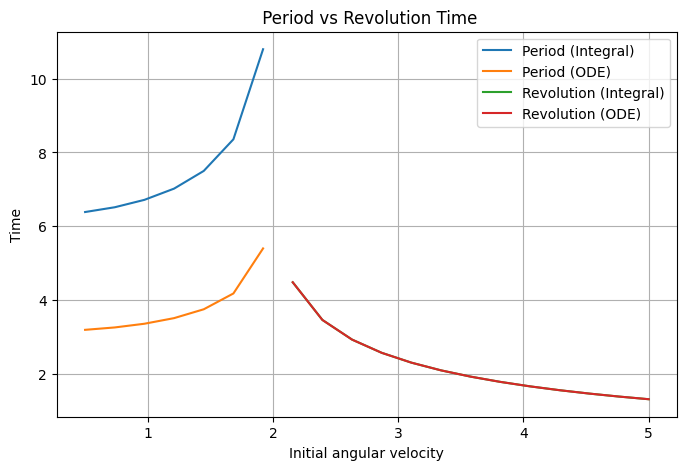

In [7]:
from re import A
from typing_extensions import TypeVarTuple
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

# define the regid pendulum ODE
def rigid_pendulum_ode (t, y, omega_0=1):
  """
  y = [theta, ang_vel]
  """
  theta, ang_vel = y
  dtheta_dt = ang_vel
  d2theta_dt2 = -omega_0**2 * np.sin(theta)
  return [dtheta_dt, d2theta_dt2]

# define revolution time and period
def period (theta, theta_0, omega_0=1):
  coeff = 4 / (np.sqrt(2) * omega_0)
  denom = np.sqrt(np.cos(theta) - np.cos(theta_0))
  return coeff / denom

# The original revolution_time function was incorrect and unused, it's removed.

# functions for solve_ivp
def event_peak(t, y, *args):
  return y[1]
event_peak.direction = -1
event_peak.terminal = True

def event_revolution (t, y, *args):
  return y[0] - 2*np.pi
event_revolution.direction = 1
event_revolution.terminal = True

# plotting
def basic_plot(x, y, xlabel=None, ylabel=None, label=None):
  plt.plot(x, y, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)

# now usiing "quad" integral method
def compute_period_integral(amplitude, omega_0=1):
  # If amplitude is zero, the period is infinite (or undefined).
  if amplitude == 0:
      return np.nan # Use NaN for plotting consistency when no oscillation

  def period_integrand(theta, amp, omega_0_val):
      # Denominator becomes zero at theta = amp (upper limit of integration)
      return 1 / np.sqrt(np.cos(theta) - np.cos(amp))

  try:
      period, _ = quad(period_integrand, 0, amplitude, args=(amplitude, omega_0), limit=200)
  except Exception as e:
      # print(f"Error in quad for period_integral with amplitude={amplitude}: {e}") # For debugging
      return np.nan
  return 4 * period / (np.sqrt(2) * omega_0)


def compute_revolution_integral(system_energy_val, omega_0=1):
  # Critical energy for revolution is E >= omega_0**2 (which is 1 for omega_0=1)
  if system_energy_val < omega_0**2:
      return np.nan

  # If energy is exactly omega_0**2, the pendulum just barely makes it over the top, period is infinite.
  if np.isclose(system_energy_val, omega_0**2):
      return np.inf

  def revolution_integrand(theta, E_val, omega_0_val):
      # The kinetic energy is T = 0.5 * (dtheta/dt)^2
      # The potential energy is V = -omega_0^2 * cos(theta)
      # Total energy E = T + V => 0.5 * (dtheta/dt)^2 = E + omega_0^2 * cos(theta)
      # dtheta/dt = sqrt(2 * (E + omega_0^2 * cos(theta)))
      # The integrand for time dt is 1 / (dtheta/dt)
      val_under_sqrt = 2 * (E_val + omega_0_val**2 * np.cos(theta))

      # For revolution (E > omega_0**2), val_under_sqrt should always be positive.
      if val_under_sqrt <= 0:
          # This indicates a problem (e.g., energy insufficient, or numerical issue near critical point)
          # For robustness, return inf or nan, though ideally this branch shouldn't be hit for E > omega_0**2.
          return np.inf # Should indicate a singularity or invalid state

      return 1 / np.sqrt(val_under_sqrt)

  try:
      # For E > omega_0**2, there are no singularities in (0, 2*pi).
      rev, _ = quad(revolution_integrand, 0, 2*np.pi, args=(system_energy_val, omega_0), limit=200)
  except Exception as e:
      # print(f"Error in quad for revolution_integral with system_energy_val={system_energy_val}: {e}") # For debugging
      return np.nan
  return rev

# now using "solve_ivp + events"
def compute_period_ode(theta_0, ang_vel_0, omega_0=1):
  y0 = [theta_0, ang_vel_0]
  sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0,
                  args=(omega_0,), events=event_peak, max_step=0.01)
  if sol.t_events[0].size > 0:
    # The period is the time to reach the peak from the start, multiplied by 2 (for a full oscillation)
    return 2 * sol.t_events[0][0]
  else:
    return None

def compute_revolution_ode(theta_0, ang_vel_0, omega_0=1):
  # Note: compute_revolution_ode explicitly starts from theta=0 regardless of the theta_0 argument
  y0 = [0, ang_vel_0]
  sol = solve_ivp(rigid_pendulum_ode, [0, 50], y0,
                  args=(omega_0,), events=event_revolution, max_step=0.01)
  if sol.t_events[0].size > 0:
    return sol.t_events[0][0]
  else:
    return None

#velocities
omega_0 = 1
ang_vel_list = np.linspace(0.5, 5, 20)
T_int_list = []
T_rev_int_list = []
T_ode_list = []
T_rev_ode_list = []

for ang_vel in ang_vel_list:
    theta_0_initial_pos = 0 # Initial angular position (fixed as per user request)

    # Calculate the total energy of the system based on initial conditions
    # E = Kinetic_Energy + Potential_Energy = 0.5 * ang_vel^2 - omega_0^2 * cos(theta_0_initial_pos)
    # Assuming m=1, L=1, g=1 for simplified equation, consistent with omega_0=1 implies g/L=1
    system_energy = 0.5 * ang_vel**2 - omega_0**2 * np.cos(theta_0_initial_pos)

    T_int = np.nan
    T_rev_int = np.nan

    # Determine if the pendulum oscillates or revolves based on energy
    # Critical energy for revolution is E = omega_0**2 (when ang_vel = 2*omega_0 for theta_0=0)
    if system_energy < omega_0**2: # Oscillation case
        # Calculate the maximum amplitude (theta_max) reached during oscillation
        # At theta_max, angular velocity is 0, so E = -omega_0^2 * cos(theta_max)
        # cos(theta_max) = -system_energy / omega_0^2
        cos_theta_max = -system_energy / omega_0**2
        # Ensure cos_theta_max is within valid range [-1, 1] due to floating point inaccuracies
        cos_theta_max = np.clip(cos_theta_max, -1, 1)
        theta_max = np.arccos(cos_theta_max)
        T_int = compute_period_integral(theta_max, omega_0)
    else: # Revolution case (system_energy >= omega_0**2)
        T_rev_int = compute_revolution_integral(system_energy, omega_0)

    # ODE calculations (they handle initial position and velocity directly)
    # T_ode is period if oscillating, None if revolving
    T_ode = compute_period_ode(theta_0_initial_pos, ang_vel, omega_0)
    # T_rev_ode is revolution time if revolving, None if oscillating
    T_rev_ode = compute_revolution_ode(theta_0_initial_pos, ang_vel, omega_0)

    T_int_list.append(T_int)
    T_rev_int_list.append(T_rev_int)
    T_ode_list.append(T_ode)
    T_rev_ode_list.append(T_rev_ode)

# Plot
plt.figure(figsize=(8,5))
basic_plot(ang_vel_list, T_int_list, xlabel='Initial angular velocity', ylabel='Time', label='Period (Integral)')
basic_plot(ang_vel_list, T_ode_list, xlabel='Initial angular velocity', ylabel='Time', label='Period (ODE)')
basic_plot(ang_vel_list, T_rev_int_list, xlabel='Initial angular velocity', ylabel='Time', label='Revolution (Integral)')
basic_plot(ang_vel_list, T_rev_ode_list, xlabel='Initial angular velocity', ylabel='Time', label='Revolution (ODE)')
plt.title(" Period vs Revolution Time")
plt.show()